In [1]:
import pandas as pd
from main import parse_current_state_log,parse_order_log, extract_position_events, extract_execution_details,load_price_data,build_trades_from_events,match_executions_to_trades,extract_trading_moments,merge_trades_with_real_pnl,flag_trades

state_logs_theo = "okx_bot_data/current_state.log"
state_logs_executed = "okx_bot_data/current_state.pos"

In [2]:
df_theo_state = parse_current_state_log(state_logs_theo)
df_theo_state

,timestamp,positions
0,2025-02-28 00:16:52.837000,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
1,2025-02-28 03:20:54.817900,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
2,2025-02-28 03:32:49.488100,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
3,2025-02-28 04:14:53.948500,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
4,2025-02-28 04:52:50.455300,"{'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL..."
...,...,...
618,2025-03-11 10:12:35.773900,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."
619,2025-03-11 10:22:34.885900,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."
620,2025-03-11 10:32:43.423900,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."
621,2025-03-11 10:42:40.760700,"{'CRO-USDT-SWAP': -1, 'BCH-USDT-SWAP': -1, 'ZE..."


In [3]:
df_theo_events = extract_position_events(df_theo_state)
df_theo_events

,symbol,timestamp,action,old_position,new_position
0,STX-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,-1
1,CFX-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,-1
2,IMX-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,-1
3,1INCH-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,1
4,GAS-USDT-SWAP,2025-02-28 00:16:52.837000,open,0,1
...,...,...,...,...,...
435,1INCH-USDT-SWAP,2025-03-11 00:32:40.708400,close,1,0
436,EOS-USDT-SWAP,2025-03-11 00:42:38.448100,close,1,0
437,1INCH-USDT-SWAP,2025-03-11 00:42:38.448100,open,0,1
438,APT-USDT-SWAP,2025-03-11 00:48:52.214700,open,0,-1


In [4]:
def build_trades_dataframe(df_events: pd.DataFrame) -> pd.DataFrame:
    """
    Builds a trades DataFrame with entry and exit times.
    
    Returns DataFrame with:
    - symbol, entry_time, exit_time, side
    """
    open_positions = {}
    completed_trades = []

    for _, row in df_events.iterrows():
        symbol = row["symbol"]
        event_ts = row["timestamp"]
        action = row["action"]
        new_pos = row["new_position"]

        if action == "open":
            side = new_pos  # +1 or -1
            open_positions[symbol] = {
                "entry_time": event_ts,
                "side": side
            }

        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: no open record for {symbol} at {event_ts}")
                continue

            trade_info = open_positions[symbol]
            completed_trades.append({
                "symbol": symbol,
                "entry_time": trade_info["entry_time"],
                "exit_time": event_ts,
                "side": trade_info["side"]
            })
            del open_positions[symbol]

    return pd.DataFrame(completed_trades)


def calculate_theoretical_pnl(df_trades: pd.DataFrame, df_prices: pd.DataFrame, number_of_positions = 16, exposure: float = 1.0) -> pd.DataFrame:
    """
    Calculates theoretical PNL using constant dollar exposure strategy.
    Sums (close/open - 1) over candles between entry and exit times.
    
    Args:
    - df_trades: DataFrame with symbol, entry_time, exit_time, side
    - df_prices: OHLCV DataFrame with columns like SYMBOL_open, SYMBOL_close
    - number_of_positions: number of position into which the total invested sum is equally subdivided
    - exposure: Dollar amount of exposure (default $1)
    
    Returns DataFrame with added columns:
    pnl calculate with convention of leverage 2
    - theo_pnl (cumulative PNL in percentage)
    - dollar_pnl (PNL in dollars based on exposure)
    """
    df_trades = df_trades.copy()
    df_trades["theo_pnl"] = 0.0
    df_trades["dollar_pnl"] = 0.0
    
    for idx, trade in df_trades.iterrows():
        symbol = trade["symbol"]
        entry_time = trade["entry_time"]
        exit_time = trade["exit_time"]
        side = trade["side"]
        
        # Get price columns for this symbol
        open_col = f"{symbol}_open"
        close_col = f"{symbol}_close"
        
        if open_col not in df_prices.columns or close_col not in df_prices.columns:
            print(f"WARNING: Price data missing for {symbol}")
            continue
        
        # Filter price data between entry and exit times
        mask = (df_prices.index >= entry_time) & (df_prices.index <= exit_time)
        df_period = df_prices.loc[mask, [open_col, close_col]].dropna()
        
        if df_period.empty:
            print(f"WARNING: No price data for {symbol} between {entry_time} and {exit_time}")
            continue
        
        # Calculate incremental returns for each candle
        returns = (df_period[close_col] / df_period[open_col]) - 1
        if side == -1:  # Short position: invert returns
            returns = -returns
        
        # Sum returns for total PNL percentage
        total_pnl_pcg = (returns.sum())/number_of_positions
        df_trades.loc[idx, "theo_pnl"] = total_pnl_pcg
        df_trades.loc[idx, "dollar_pnl"] = total_pnl_pcg * exposure
    
    return df_trades

In [5]:
# Paths
theo_log_path = "okx_bot_data/current_state.log"
price_path = "okx_bot_data/price_data_okx.csv"  # Your OHLCV data

# Parse theoretical positions
df_theo_log = parse_current_state_log(theo_log_path)
print("Theoretical Positions:")
print(df_theo_log.head())
print("=" * 60)

# Extract events
df_theo_events = extract_position_events(df_theo_log)
print("Theoretical Events:")
print(df_theo_events.head())
print("=" * 60)

Theoretical Positions:
                   timestamp  \
0 2025-02-28 00:16:52.837000   
1 2025-02-28 03:20:54.817900   
2 2025-02-28 03:32:49.488100   
3 2025-02-28 04:14:53.948500   
4 2025-02-28 04:52:50.455300   

                                           positions  
0  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
1  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
2  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
3  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
4  {'AXS-USDT-SWAP': 1, 'DOGE-USDT-SWAP': 1, 'ZIL...  
Theoretical Events:
            symbol               timestamp action  old_position  new_position
0    STX-USDT-SWAP 2025-02-28 00:16:52.837   open             0            -1
1    CFX-USDT-SWAP 2025-02-28 00:16:52.837   open             0            -1
2    IMX-USDT-SWAP 2025-02-28 00:16:52.837   open             0            -1
3  1INCH-USDT-SWAP 2025-02-28 00:16:52.837   open             0             1
4    GAS-USDT-SWAP 2025-02-28 00:16:52.837  

In [6]:
# Build trades DataFrame
df_trades = build_trades_dataframe(df_theo_events)
print("Trades DataFrame:")
print(df_trades.head())
print("=" * 60)

# Load OHLCV prices
df_prices = load_price_data(price_path)
print("Price Data:")
print(df_prices.head())
print("=" * 60)


Trades DataFrame:
           symbol              entry_time                  exit_time  side
0   WOO-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 03:20:54.817900     1
1  CELO-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 03:32:49.488100     1
2   CFX-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 04:14:53.948500    -1
3   ETC-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 04:52:50.455300     1
4   UMA-USDT-SWAP 2025-02-28 00:16:52.837 2025-02-28 05:42:49.531700     1
Price Data:
                     AXS-USDT-SWAP_open  AXS-USDT-SWAP_high  \
date                                                          
2025-02-27 23:03:00               3.656               3.660   
2025-02-27 23:06:00               3.656               3.658   
2025-02-27 23:09:00               3.649               3.652   
2025-02-27 23:12:00               3.652               3.653   
2025-02-27 23:15:00               3.650               3.660   

                     AXS-USDT-SWAP_low  AXS-USDT-SWAP_close  \
date           

In [7]:
# Calculate theoretical PNL
exposure = 1.0  # $1 exposure per trade; adjust as needed
df_trades_with_pnl = calculate_theoretical_pnl(df_trades, df_prices, exposure=exposure)
print("Trades with Theoretical PNL:")
print(df_trades_with_pnl[["symbol", "entry_time", "exit_time", "side", "theo_pnl", "dollar_pnl"]])
print("=" * 60)


Trades with Theoretical PNL:
              symbol                 entry_time                  exit_time  \
0      WOO-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 03:20:54.817900   
1     CELO-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 03:32:49.488100   
2      CFX-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 04:14:53.948500   
3      ETC-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 04:52:50.455300   
4      UMA-USDT-SWAP 2025-02-28 00:16:52.837000 2025-02-28 05:42:49.531700   
..               ...                        ...                        ...   
199   BLUR-USDT-SWAP 2025-03-07 04:17:39.562100 2025-03-10 20:32:52.183300   
200    EOS-USDT-SWAP 2025-03-10 10:28:39.477300 2025-03-11 00:30:00.000000   
201  1INCH-USDT-SWAP 2025-03-11 00:30:00.000000 2025-03-11 00:32:40.708400   
202    EOS-USDT-SWAP 2025-03-11 00:32:40.708400 2025-03-11 00:42:38.448100   
203    IMX-USDT-SWAP 2025-03-10 17:12:47.784100 2025-03-11 00:48:52.214700   

     side  theo_pnl  dollar_pnl  


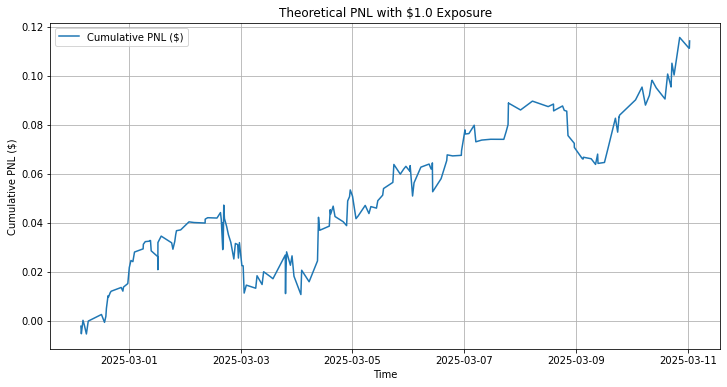

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Save results
df_trades_with_pnl.to_csv("theoretical_trades_with_pnl.csv", index=False)

# Optional: Plot cumulative PNL
df_trades_with_pnl.sort_values("exit_time", inplace=True)
df_trades_with_pnl["cumulative_dollar_pnl"] = (df_trades_with_pnl["dollar_pnl"].cumsum())
plt.figure(figsize=(12, 6))
plt.plot(df_trades_with_pnl["exit_time"].to_numpy(), df_trades_with_pnl["cumulative_dollar_pnl"].to_numpy(), label="Cumulative PNL ($)")
plt.xlabel("Time")
plt.ylabel("Cumulative PNL ($)")
plt.title(f"Theoretical PNL with ${exposure} Exposure")
plt.legend()
plt.grid()
plt.savefig("cumulative_theo_pnl.png", dpi=300)
plt.show()

In [12]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def parse_executed_positions_log(log_path: str) -> pd.DataFrame:
    """
    Reads current_state.pos (executed positions) for OKX, ignoring 'equity' field.
    Format: 2025/03/01 12:20:38.977684:'LUNC-USDT-SWAP':-20140000.0, ..., 'equity':67.81341999999995
    
    Returns DataFrame with:
    - timestamp (datetime)
    - positions (dict of symbol->float, raw position size, excluding 'equity')
    - directions (dict of symbol->int, 1 for long, -1 for short, 0 for no position)
    """
    pattern = re.compile(r"'([^']+)':([-]?\d+\.\d+|\d+)")
    rows = []
    
    try:
        with open(log_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                dt_str = line[:24]
                rest = line[24:].strip()
                
                dt = datetime.strptime(dt_str, "%Y/%m/%d %H:%M:%S.%f")
                pairs = pattern.findall(rest)
                # Filter out 'equity' and treat only symbol-position pairs
                positions_dict = {sym: float(pos) for sym, pos in pairs if sym != 'equity'}
                directions_dict = {sym: 1 if pos > 0 else -1 if pos < 0 else 0 for sym, pos in positions_dict.items()}
                
                rows.append({
                    "timestamp": dt,
                    "positions": positions_dict,
                    "directions": directions_dict
                })
    except FileNotFoundError as e:
        print(f"ERROR: File not found: {log_path}")
        raise e

    df = pd.DataFrame(rows)
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def get_next_bar_price(symbol: str, ts: pd.Timestamp, df_prices: pd.DataFrame, column: str = "close", fallback: bool = False) -> float:
    """Helper function to get the next available price."""
    col = f"{symbol}_{column}"
    if col not in df_prices.columns:
        return float("nan")
    prices_after = df_prices[df_prices.index >= ts][col]
    if not prices_after.empty:
        return prices_after.iloc[0]
    if fallback:
        prices_before = df_prices[df_prices.index <= ts][col]
        if not prices_before.empty:
            return prices_before.iloc[-1]
    return float("nan")

def process_executed_positions(df_log: pd.DataFrame, df_prices: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Processes executed positions to calculate values and detect events, tracking rebalancing prices.
    
    Returns:
    - df_values: timestamp, symbol, position_size, direction, dollar_value
    - df_events: symbol, timestamp, action, old_size, new_size, price, old_value, new_value
    """
    df_log = df_log.copy()
    df_log.sort_values("timestamp", inplace=True)
    df_log.reset_index(drop=True, inplace=True)
    
    # Insert dummy row
    first_ts = df_log.loc[0, "timestamp"] if not df_log.empty else pd.Timestamp.now()
    dummy_ts = first_ts - pd.Timedelta(microseconds=1)
    dummy_row = pd.DataFrame({"timestamp": [dummy_ts], "positions": [{}], "directions": [{}]})
    df_log = pd.concat([dummy_row, df_log], ignore_index=True)
    
    values = []
    events = []
    
    for i in range(len(df_log) - 1):
        curr_ts = df_log.loc[i, "timestamp"]
        next_ts = df_log.loc[i + 1, "timestamp"]
        curr_pos = df_log.loc[i, "positions"]
        next_pos = df_log.loc[i + 1, "positions"]
        curr_dir = df_log.loc[i, "directions"]
        next_dir = df_log.loc[i + 1, "directions"]
        
        all_symbols = set(curr_pos.keys()).union(next_pos.keys())
        
        for sym in all_symbols:
            old_size = curr_pos.get(sym, 0.0)
            new_size = next_pos.get(sym, 0.0)
            old_dir = curr_dir.get(sym, 0)
            new_dir = next_dir.get(sym, 0)
            
            price = get_next_bar_price(sym, next_ts, df_prices, column="close")
            if pd.isna(price):
                price = get_next_bar_price(sym, next_ts, df_prices, column="close", fallback=True)
                if pd.isna(price):
                    print(f"WARNING: No price for {sym} at {next_ts}")
                    price = 0.0
            
            new_value = new_size * price
            
            if new_dir != 0:
                values.append({
                    "timestamp": next_ts,
                    "symbol": sym,
                    "position_size": new_size,
                    "direction": new_dir,
                    "dollar_value": new_value
                })
            
            if old_dir != new_dir:
                old_value = old_size * price
                if old_dir == 0 and new_dir != 0:
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "open",
                        "old_size": old_size,
                        "new_size": new_size,
                        "price": price,
                        "old_value": 0.0,
                        "new_value": new_value
                    })
                elif old_dir != 0 and new_dir == 0:
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "close",
                        "old_size": old_size,
                        "new_size": new_size,
                        "price": price,
                        "old_value": old_value,
                        "new_value": 0.0
                    })
                else:
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "close",
                        "old_size": old_size,
                        "new_size": 0.0,
                        "price": price,
                        "old_value": old_value,
                        "new_value": 0.0
                    })
                    events.append({
                        "symbol": sym,
                        "timestamp": next_ts,
                        "action": "open",
                        "old_size": 0.0,
                        "new_size": new_size,
                        "price": price,
                        "old_value": 0.0,
                        "new_value": new_value
                    })
            elif old_dir == new_dir and old_dir != 0 and abs(new_size - old_size) > 1e-6:
                old_value = old_size * price
                events.append({
                    "symbol": sym,
                    "timestamp": next_ts,
                    "action": "rebalance",
                    "old_size": old_size,
                    "new_size": new_size,
                    "price": price,
                    "old_value": old_value,
                    "new_value": new_value
                })
    
    df_values = pd.DataFrame(values)
    df_events = pd.DataFrame(events)
    df_values.sort_values("timestamp", inplace=True)
    df_events.sort_values("timestamp", inplace=True)
    return df_values, df_events

In [15]:
def calculate_realized_pnl(df_events: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculates realized PNL with mean acquisition price tracking, handling zero-size cases.
    
    Returns:
    - df_position_pnl: symbol, entry_time, exit_time, realized_pnl (rebalancing + closing)
    - df_portfolio_pnl: timestamp, portfolio_pnl (incremented with each event)
    - df_pnl_events: symbol, timestamp, action, price, realized_pnl, mean_acq_price
    """
    open_positions = {}  # {symbol: {"entry_time": ts, "size": float, "total_cost": float, "total_size": float}}
    position_pnl = {}    # {symbol_entry: cumulative_pnl}
    portfolio_pnl = []   # [(timestamp, pnl)]
    pnl_events = []
    total_portfolio_pnl = 0.0
    
    for _, event in df_events.iterrows():
        symbol = event["symbol"]
        ts = event["timestamp"]
        action = event["action"]
        old_size = event["old_size"]
        new_size = event["new_size"]
        price = event["price"]
        
        if action == "open":
            open_positions[symbol] = {
                "entry_time": ts,
                "size": new_size,
                "total_cost": new_size * price,
                "total_size": abs(new_size)
            }
            position_pnl[f"{symbol}_{ts}"] = 0.0
        
        elif action == "rebalance":
            if symbol not in open_positions:
                print(f"WARNING: Rebalance without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            direction = 1 if old_size > 0 else -1
            size_change = old_size - new_size  # Positive if reducing position
            
            if abs(new_size) < 1e-6:  # Treat as close if new_size is effectively zero
                mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                realized_pnl = old_size * (price - mean_acq_price) * direction
                key = f"{symbol}_{pos['entry_time']}"
                position_pnl[key] += realized_pnl
                total_portfolio_pnl += realized_pnl
                pnl_events.append({
                    "symbol": symbol,
                    "timestamp": ts,
                    "action": "close",
                    "price": price,
                    "realized_pnl": realized_pnl,
                    "mean_acq_price": mean_acq_price
                })
                portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
                del open_positions[symbol]
            else:
                # Normal rebalancing
                mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                realized_pnl = size_change * (price - mean_acq_price) * direction
                
                # Update position
                if size_change > 0:  # Reduced position
                    if pos["total_size"] != 0:
                        pos["total_cost"] -= size_change * mean_acq_price
                    pos["total_size"] -= abs(size_change)
                else:  # Increased position
                    pos["total_cost"] += abs(size_change) * price
                    pos["total_size"] += abs(size_change)
                
                pos["size"] = new_size
                key = f"{symbol}_{pos['entry_time']}"
                position_pnl[key] += realized_pnl
                total_portfolio_pnl += realized_pnl
                new_mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
                pnl_events.append({
                    "symbol": symbol,
                    "timestamp": ts,
                    "action": "rebalance",
                    "price": price,
                    "realized_pnl": realized_pnl,
                    "mean_acq_price": new_mean_acq_price
                })
                portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
        
        elif action == "close":
            if symbol not in open_positions:
                print(f"WARNING: Close without open position for {symbol} at {ts}")
                continue
            
            pos = open_positions[symbol]
            direction = 1 if old_size > 0 else -1
            mean_acq_price = pos["total_cost"] / pos["total_size"] if pos["total_size"] != 0 else 0.0
            realized_pnl = old_size * (price - mean_acq_price) * direction
            
            key = f"{symbol}_{pos['entry_time']}"
            position_pnl[key] += realized_pnl
            total_portfolio_pnl += realized_pnl
            pnl_events.append({
                "symbol": symbol,
                "timestamp": ts,
                "action": "close",
                "price": price,
                "realized_pnl": realized_pnl,
                "mean_acq_price": mean_acq_price
            })
            portfolio_pnl.append({"timestamp": ts, "portfolio_pnl": total_portfolio_pnl})
            del open_positions[symbol]
    
    # Position lifetime PNL
    position_records = []
    for key, pnl in position_pnl.items():
        symbol, entry_time = key.rsplit("_", 1)
        entry_time = pd.Timestamp(entry_time)
        exit_time = df_events[
            (df_events["symbol"] == symbol) & 
            (df_events["timestamp"] >= entry_time) & 
            (df_events["action"] == "close")
        ]["timestamp"].min()
        position_records.append({
            "symbol": symbol,
            "entry_time": entry_time,
            "exit_time": exit_time,
            "realized_pnl": pnl
        })
    
    df_position_pnl = pd.DataFrame(position_records)
    df_portfolio_pnl = pd.DataFrame(portfolio_pnl).drop_duplicates(subset="timestamp", keep="last")
    df_pnl_events = pd.DataFrame(pnl_events)
    return df_position_pnl, df_portfolio_pnl, df_pnl_events

Executed Positions:
                   timestamp  \
0 2025-03-01 12:20:38.977600   
1 2025-03-01 12:20:38.977600   
2 2025-03-01 12:20:38.977600   
3 2025-03-01 12:20:38.977600   
4 2025-03-01 12:20:38.977600   

                                           positions  \
0  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
1  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
2  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
3  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   
4  {'LUNC-USDT-SWAP': -20140000.0, 'PYTH-USDT-SWA...   

                                          directions  
0  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
1  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
2  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
3  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
4  {'LUNC-USDT-SWAP': -1, 'PYTH-USDT-SWAP': 1, 'D...  
Position Values:
                     timestamp          symbol  position_size  direction  \
0   2025-03-01 12:20:38.977

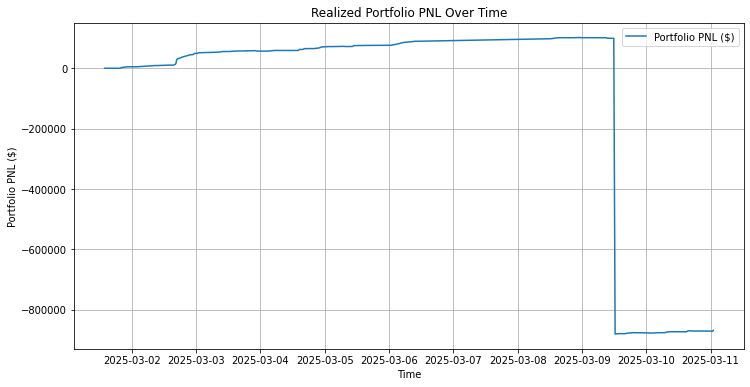

In [17]:
# Paths
exec_log_path = "okx_bot_data/current_state.pos"
price_path = "okx_bot_data/price_data_okx.csv"

# Parse executed positions
df_exec_log = parse_executed_positions_log(exec_log_path)
print("Executed Positions:")
print(df_exec_log.head())
print("=" * 60)

# Process positions
df_values, df_events = process_executed_positions(df_exec_log, df_prices)
print("Position Values:")
print(df_values.head())
print("Events:")
print(df_events.head())
print("=" * 60)

# Calculate PNL
df_position_pnl, df_portfolio_pnl, df_pnl_events = calculate_realized_pnl(df_events)
print("Position Lifetime PNL:")
print(df_position_pnl)
print("Portfolio PNL Over Time:")
print(df_portfolio_pnl)
print("PNL Events:")
print(df_pnl_events)
print("=" * 60)

# Validation
total_position_pnl = df_position_pnl["realized_pnl"].sum()
final_portfolio_pnl = df_portfolio_pnl["portfolio_pnl"].iloc[-1] if not df_portfolio_pnl.empty else 0.0
print(f"Total Position PNL: {total_position_pnl:.2f}")
print(f"Final Portfolio PNL: {final_portfolio_pnl:.2f}")
print(f"Difference: {total_position_pnl - final_portfolio_pnl:.2f}")

# Save results
df_values.to_csv("position_values.csv", index=False)
df_events.to_csv("position_events.csv", index=False)
df_position_pnl.to_csv("position_pnl.csv", index=False)
df_portfolio_pnl.to_csv("portfolio_pnl.csv", index=False)
df_pnl_events.to_csv("pnl_events.csv", index=False)

# Plot portfolio PNL
plt.figure(figsize=(12, 6))
plt.plot(df_portfolio_pnl["timestamp"].to_numpy(), df_portfolio_pnl["portfolio_pnl"].to_numpy(), label="Portfolio PNL ($)")
plt.xlabel("Time")
plt.ylabel("Portfolio PNL ($)")
plt.title("Realized Portfolio PNL Over Time")
plt.legend()
plt.grid()
plt.savefig("portfolio_pnl.png", dpi=300)
plt.show()

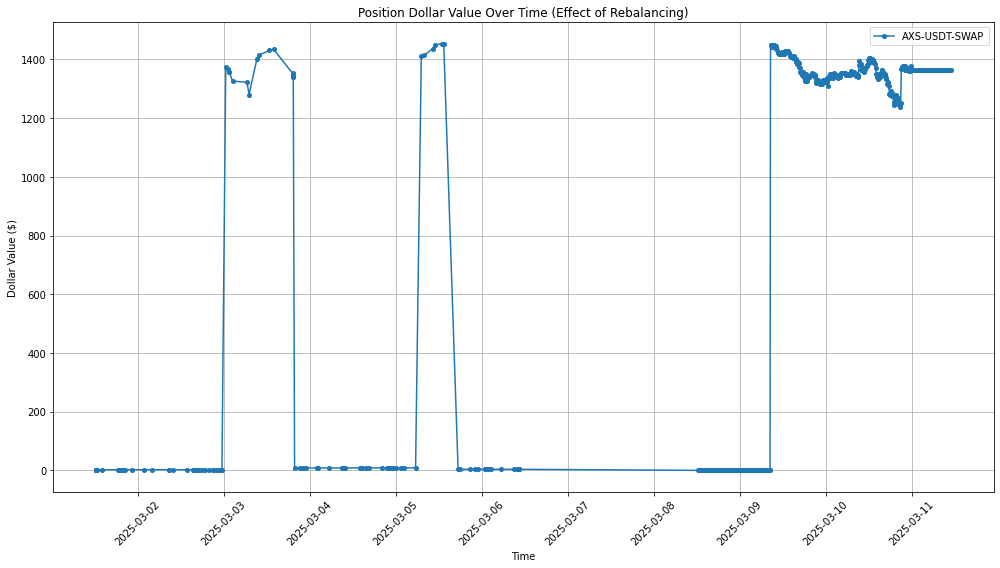

In [26]:
# Plot position dollar values for specific symbols
symbols_to_plot = ['AXS-USDT-SWAP']  # Replace with your desired symbols
plt.figure(figsize=(14, 8))

for symbol in symbols_to_plot:
    df_symbol = df_values[df_values["symbol"] == symbol]
    if not df_symbol.empty:
        plt.plot(df_symbol["timestamp"].to_numpy(), df_symbol["dollar_value"].to_numpy(), label=f"{symbol}", marker='o', markersize=4)
    else:
        print(f"WARNING: No data found for {symbol} in df_values")

plt.xlabel("Time")
plt.ylabel("Dollar Value ($)")
plt.title("Position Dollar Value Over Time (Effect of Rebalancing)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("position_values_over_time.png", dpi=300)
plt.show()